__ TOOLS FOR MANAGING THE ELECTION. NOT FOR REPORTING. __

2019!

In [1]:
%cd ~/Dropbox/csun-election-management


#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set(style="whitegrid")

#Base Classes stuff
from FileSystemTools import *
from UtilityDecorators import *
from UtilityFunctions import *

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

import counter.environment as env
from counter.QualitricsHelpers import get_results_column_names, get_write_in_column_names
from counter.QualitricsProcessors import process_field, process_voter, process_office_columns
from counter.FileSystemTools import makeDataFileList
# String processing of result cells
from counter.StringProcessors import find_dept, remove_depts

/Users/adam/Dropbox/csun-election-management


# Load and process data

## Get results files

In [2]:
results_files = [f for f in makeDataFileList(env.INPUT_FOLDER_PATH) if f[-3:] == 'csv']
# results_files

In [3]:
data = pd.read_csv(results_files[0])
# data

## Remove non-response rows

In [4]:
dropped = data[data.index <= 1]
data = data[data.index > 1]

# Verify that no actual responses were dropped
dropped

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q1,Q1_5_TEXT,Q1_6_TEXT,Q2,Q3,Q3_5_TEXT,Q3_6_TEXT
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Choose which word best describes your mood today.,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID4""}","{""ImportId"":""QID4_5_TEXT""}","{""ImportId"":""QID4_6_TEXT""}","{""ImportId"":""QID6""}","{""ImportId"":""QID4""}","{""ImportId"":""QID4_5_TEXT""}","{""ImportId"":""QID4_6_TEXT""}"


In [13]:
from counter.Exceptions import OfficeProcessingError
from counter.DataObjects import OfficeElection
from counter.Definitions import OfficeDefinitions

# Read in the properties of the various offices
Definitions = OfficeDefinitions()

def process_results(frame):
    """This is the master processing function
    Returns a list of results objects for each office where no errors
    were encountered.
    """
    results = []
    results_columns = get_results_column_names(frame)
    for c in results_columns:
        # create a data store object
        office_name = Definitions.get_office_name_for_field(c)
        write_in_columns = get_write_in_column_names(frame, c)
        r = OfficeElection(officeName=office_name, fieldName=c, writeInFieldNames=write_in_columns)
        # it will pull out the relevant columns
        r.add_data(frame)
        try:
            office_counts = process_office_columns(frame, r)
            results.append(r)
        except OfficeProcessingError as err:
            # These blocked the results object from being added to the 
            # results list
            print("Error proccessing office: {}".format(office_name))
            for e in err.errors:
                print(e)
    return results


def save_results(output_file, results):
    """Writes results to output file"""
    with pd.ExcelWriter(output_file) as writer:
        for result in results:
#             print("Writing results of {} to file".format(result.officeName))
            result.vote_counts.to_excel(writer, sheet_name=result.officeName)


In [14]:
results = process_results(data)
save_results(env.OUTPUT_FILE, results)

Error proccessing office: Vice-President
[Possible vote-stuffing error] row 7 selected ['Dwayne Johnson', 'Dwayne Johnson'] 


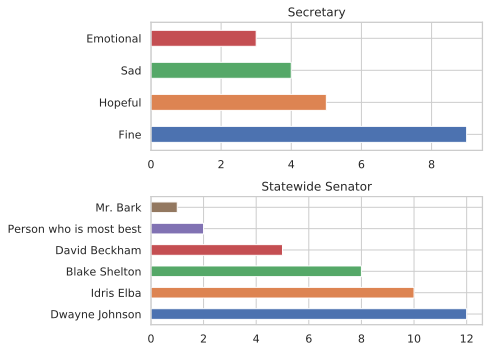

In [12]:
fig, axes = plt.subplots(nrows=len(results), figsize=(7,5))
i = 0
for r in results:
    r.vote_counts.plot(kind='barh', title=r.officeName, ax=axes[i])
    i+=1
fig.tight_layout()

## Abstentions

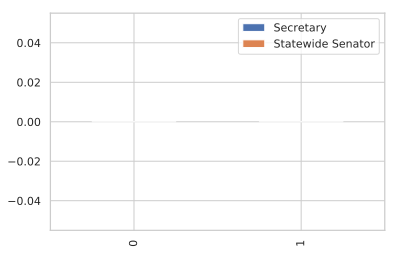

In [12]:
d = []
for r in results:
    d.append({r.officeName : r.number_abstentions})
pd.DataFrame(d).plot(kind='bar')

In [11]:
results[0].total_voters

6

In [ ]:
def process_field(field, keep_depts=False):
    """Extracts all votes from a given cell"""
    print(field)
    if not keep_depts:
        field = remove_depts(field)
    votes = field.split(',')
    # clean up whitespace
    votes = [v.strip() for v in votes]
    return votes

# test
for raw, expected in test_cases:
    assert(process_field(raw) == expected)

In [ ]:
def process_office(frame, column):
    """Returns a series with vote counts of all the selections
    NB, this does not handle write-ins"""
    votes = []
    for field in frame[column]:
        votes += process_field(field)
    # Make votes into a series and count it
    votes = pd.Series(votes, name='number_votes')
    return votes.value_counts()


In [ ]:
def process_office_writeins(frame, writein_cols):
    """Returns a series with vote counts of written in candidates"""
#     writein_cols = get_write_in_columns(frame, question_number)
    votes = []
    for column in writein_cols:
        for field in frame[column]:
            print(field)
            if not pd.isnull(field):
                votes.append(field)
#             votes += process_field(field, keep_depts=True)
    # Make votes into a series and count it
    votes = pd.Series(votes, name='number_votes')
    return votes.value_counts()


In [ ]:
def process_voter(row, main_column, write_in_columns):
    """Process all the fields for an individual voter"""
    votes = []
    # process the main vote column
    votes += process_field(row[main_column])
    # process the write ins
    for column in write_in_columns:
        if not pd.isnull(row[column]):
            votes.append(row[column])
    # Checks for illegal votes go here
    
    return votes



def process_office_columns(frame, main_column, write_in_columns):
    """
    main_column: String label of the main vote column (e.g., 'Q1')
    """
    office_columns = [main_column] + write_in_columns
    office_votes = []
    
    for idx, row in frame[office_columns].iterrows():
        office_votes += process_voter(row, main_column, write_in_columns)

    # Make votes into a series and count it
    office_votes = pd.Series(office_votes, name='number_votes')
    return office_votes.value_counts()


In [ ]:
# process_office_columns(data, 'Q1', ['Q1_5_TEXT', 'Q1_6_TEXT'])

In [ ]:
from counter.Exceptions import InvalidatesVote
import pandas as pd
# import counter.environment as env
from counter.FileSystemTools import makeDataFileList

__author__ = 'adam'

# from collections import namedtuple
# OfficeElection = namedtuple('OfficeElection', ['officeName', 'fieldName', 'candidateNames', 'maxValid'])

class OfficeDefinitions(object):

    def __init__(self, definitions_folder=env.ELECTION_DEF_FILES_PATH):
        self.def_map = {
            'office': ['Office', 'office'],
            'field': ['Canvas column name', 'Results column name'],
            'max': ['Maximum selections allowed'],
            'requires_maj': ['Requires majority']
        }

        self._load(definitions_folder)

    def _load( self , definitions_folder):
        files = [f for f in makeDataFileList(definitions_folder) if f[-3:] == 'xls']

        self.defs = pd.read_excel(files[0])

    @property
    def office_name( self ):
        names = self.def_map.get('office')
        for c in names:
            if c in self.defs.columns:
                return self.defs[c][0]











In [12]:
from counter.Definitions import OfficeDefinitions
d=OfficeDefinitions()
d.get_office_name_for_field('Q2')

'e'

# Problem cases

2 candidates with same name
    
    Same dept
    
    Different dept
    
Write in candidate with no dept

Write in candidate with dept in parentheses

Write in candidate with dept, no parentheses

Vote for 1 candidate, write in same candidate (up to num allowed -1)

Write in multiple candidates in one field

Write same candidate in multiple times

# Questions

Do we need to check the 'Finished' field?

Do they have to vote on every office?

In [ ]:
test_field = "Idris Elba (Age 46),Dwayne Johnson (Age 48)"

In [ ]:
test_field[test_field.find("(") : test_field.find(")") +1]

In [ ]:
s[s.find("(")+1:s.find(")")]

In [ ]:
find_dept(test_field)

In [ ]:
remove_depts(test_field)

In [ ]:
generalData = pd.read_excel(electionReturnsFilePath, sheet_name='Data-general')
generalData.set_index('Year', inplace=True)
generalEligible = generalData['Eligible']
generalData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
generalData.dropna(axis=1, how='all', inplace=True)

senateData = pd.read_excel(electionReturnsFilePath, sheet_name='Data-senate')
senateData.set_index('Year', inplace=True)
senateEligible = senateData['Eligible']
senateData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
senateData.dropna(axis=1, how='all', inplace=True)


def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

generalProport = generalData.apply(lambda x : calc_proport_of_eligible(generalEligible, x.index, x))
senateProport =  senateData.apply(lambda x : calc_proport_of_eligible(senateEligible, x.index, x))

# General election

## Total votes cast

In [ ]:
generalData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalData.T.plot(ax=axes)
axes.set_title("General election -- total votes")
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalProport.T.plot(ax=axes)
axes.set_title("General election returns -- proportion of eligible voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Daily marginal votes cast

In [ ]:
generalMarginal = generalData.T.sub(generalData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
generalMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=generalMarginal.dropna(axis=1), ax=axes)
axes.set_title("General election - marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (generalMarginal.index.min(), generalMarginal.index.max()))
fig.tight_layout()

# Senate-elected positions election 

## Total votes cast

In [ ]:
senateData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateData.T.plot(ax=axes)
axes.set_title("Senate-elected positions election --- total votes")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Votes cast per day

In [ ]:
senateMarginal = senateData.T.sub(senateData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
senateMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=senateMarginal.dropna(axis=1), ax=axes)
axes.set_title("Senate-elected positions -- marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (senateMarginal.index.min(), senateMarginal.index.max()))
fig.tight_layout()

# Election design and machinery

## Quick primer on elections 

Clarify categories of vote

Illegal: 
    - The ballot expresses a preference which cannot be satisfied within the bounds of the election.
    - The most common illegal ballots in this election involved: 
        - The voter selecting more than the allowed number of candidates; or, 
        - Xelecting the maximum number and then writing in an additional candidate.

Cast = abstentions + legal + illegal
- Cast plays no role except for auditing 

valid = legal + illegal
- These determine the denominator when a position requires a majority (i.e., > 50%)



In [ ]:
ELECTION_YEAR = 2018
resultsFolder = "%s/Box Sync/Faculty Senate Collaborative Documents/Elections/Results/" % BASE
currentElection = "%s/%s Elections official results" % (resultsFolder, ELECTION_YEAR)
senateFolder = "%s/senate official results" % currentElection
generalFolder = "%s/general official results" % currentElection

In [ ]:
resultFileString = "Results.xlsx"
senateFiles = [f for f in makeDataFileList(senateFolder) if f[-12:] == resultFileString]
generalFiles = [f for f in makeDataFileList(generalFolder) if f[-12:] == resultFileString]
senateFrames = [pd.read_excel(f) for f in senateFiles]
generalFrames = [pd.read_excel(f) for f in generalFiles]

In [ ]:
def number_of_abstentions(frame):
    """Returns the number of blank ballots minus the
    number of write in votes"""
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
    abstentions = frame[frame[committeeName] == 'abstentions']['votes']
    abstentions = int(abstentions)
    # now we need to subtract the writeins
    # since any write-in will be  counted as an
    # abstention
    #
    # !!!!!!!!!!!!! todo double-check in code
    try:
        wi = frame[frame[committeeName] == 'writeins-unverified']['votes']
        wi = int(wi)        
        abstentions = abstentions + wi
    except:
        pass
    return (committeeName, abstentions)

def number_of_illegal_overselections(frame):
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
#     print(committeeName)
    v = frame[frame[committeeName] == 'illegal-overselection']['votes']
    v = int(v)
    return (committeeName, v)

def number_manually_disqualified(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    # get rid of any of the programmatically added columns
    v = frame.dropna()
    # add up the disqualified votes
    v = int(v.dq.sum())
    return (committeeName, v)

def number_illegal(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    #programmaticOverselections: too many boxes ticked
    po = number_of_illegal_overselections(frame)
    #write ins which invalidated the vote
    wi = number_manually_disqualified(frame)
    num =  po[1] + wi[1]
    return (committeeName, num)  

In [ ]:
def get_frame_for_plotting(func, columnName):
    v =  [func(frame) for frame in senateFrames]
    v =  v + [func(frame) for frame in generalFrames]
    return DataFrame(v, columns=['election', columnName]).set_index('election')

def plot_frame(frame, title, ylabel):
    fig, axes = plt.subplots(figsize=(8,3))
    frame.plot(kind='bar', table=True, ax=axes)
    x_axis = axes.get_xaxis(); axes.set_ylabel(ylabel)
    x_axis.set_visible(False); axes.set_title(title)
    fig.tight_layout()

In [ ]:
overselections = get_frame_for_plotting(number_of_illegal_overselections, 'over-selections')
plot_frame(overselections,  'Number ballots spoiled by too many candidates being selected', 'count')


## Write-in boxes


In [ ]:
dq = get_frame_for_plotting(number_manually_disqualified, 'disqualified')
plot_frame(dq,"Number of ballots disqualified due to write-ins", "# of ballots disqualified")

### Abstentions 


### Abstentions 

Finally, it's worth looking briefly at rates of abstention. Those on the Senate know my militant view on abstentions. Holes are privations of dirt. Abstentions are privations of votes.^. 

This fits with the Robert's Rules treatment of abstentions, which governs our elections. [quote] only ballots which indicate a preference count toward vote totals. Obviously, we cannot infer from these rates that voters hated both candidates since it could've been that they loved them both equally^^ 



^ Technically, they exist but do not subsist

^^ For an argument that it isn't always rational to flip a coin in these cases, see Chang [ref]

In [ ]:
abstentions = get_frame_for_plotting(number_of_abstentions, 'abstentions')
plot_frame(abstentions, "Number of blank ballots", "# of privations")

# Questions:
- How many votes were invalid because of the overselection (illegal-overselction + invalid) in each election?

- How many abstentions were there

In [ ]:
SENATE_VOTES = 50 #todo refer to value calculated above, just need election year
SENATE_ELLIGIBLE = 71 #todo refer to value calculated above, just need election year

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in generalFrames]
# illegalVotes = DataFrame(illegalVotes, columns=['Office', 'Illegal votes'])
#abstentions

In [ ]:
generalAbstentions =  [number_of_abstentions(frame) for frame in generalFrames]
generalAbstentions = DataFrame(generalAbstentions, columns=['Position', 'Abstentions'])


In [ ]:
abstentions

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in senateFrames]
illegalVotes = DataFrame(illegalVotes, columns=['election', 'Illegal votes'])
# these are included in illegal
overselections = [number_of_illegal_overselections(frame) for frame in senateFrames]
overselections = DataFrame(overselections, columns=['election', 'Overselections'])

data = pd.merge(left=abstentions, right=illegalVotes, on='election').set_index('election')

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
data.plot(kind='bar', ax=axes)
axes.set_title("Counts of abstentions and illegal votes for standing committee elections")
axes.set_ylabel("Count")
fig.tight_layout()

In [ ]:
pctEligible = data.copy(deep=True)
pctVoters = data.copy(deep=True)
pctVoters.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)
pctEligible.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)


pctEligible['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_ELLIGIBLE)
pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

pctVoters['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_VOTES)
pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

# pctEligible['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))
# pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))

# pctVoters['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_VOTES) * 100))
# pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE) * 100))

In [ ]:
fig, axes = plt.subplots(nrows=2)
pctEligible.plot(kind='bar', ax=axes[0])
axes[0].set_title("Abstentions and illegal votes as proportion of eligible voters")
axes[0].set_ylabel("count / # eligible ")
pctVoters.plot(kind='bar', ax=axes[1])
axes[1].set_ylabel("count / # case ")
axes[1].set_title("Abstentions and illegal votes as proportion of votes cast")
fig.tight_layout()

In [ ]:
a = get_number_of_abstentions(f)

In [ ]:
int(a[1])

In [ ]:
a

In [ ]:
b= "2018-03-23_11-47 ERC Results.xlsx"

In [ ]:
b[-12:]

# Election results computation

In [ ]:
#Generic system tools
import re, pprint, sys, json, os, shutil, webbrowser

import pandas as pd

#Base Classes stuff
# from FileSystemTools import *
# from UtilityDecorators import *
# from UtilityFunctions import *


%cd "/Users/adam/Dropbox/csun-election-management"
%run -i environment

# Load the data from the csv file into a dataframe
data = load_results_into_frame(INPUT_FOLDER_PATH)
# Give each row an id (also saves copy of the modified file for audits)
add_rowIds(data, FILE_W_ROW_IDS_PATH)

%cd "/Users/adam/Dropbox/csun-election-management/counter/src/"
from DataObjects import * 
%cd "/Users/adam/Dropbox/csun-election-management/Input/Election-definitions"

import csv

def read_csv_mapping(csvFile, firstColIsKey=True):
    """Returns a dictionary mapping values in the first column to values in the second. That way
     the second column list of tuples for each row of the stored item

    Args:
        firstColIsKey (oboolean): Whether the first column in the file is to be used as keys
    """
    with open(csvFile) as csvFile:
        reader = csv.reader(csvFile, quotechar='|')
        out = {}
        for row in reader:
            if firstColIsKey:
                out[row[0]] =  row[1]
            else:
                out[row[1]] = row[0]
        return out


read_csv_mapping('Office2.csv')

import pandas as pd

data


make_election_obj_from_file('Office2.xlsx')

d = pd.read_excel('Office2.xlsx')
d.columns

fieldNames = ['953897: Choose 2 (ONLY 2) of the following:', '955923: Choose 4 (ONLY 4) of the following:']

%cd "/Users/adam/Dropbox/csun-election-management"
%run -i click_to_tabulate_votes

# considering removing dependency on pandas
import csv
def read_csv(csvFile):
    """Returns a list of tuples for each row of the stored item"""
    with open(csvFile) as csvFile:
        reader = csv.reader(csvFile, quotechar='|')
        out = []
        for row in reader:
            out.append(tuple(row))
        return out

fileList = makeDataFileList(INPUT_FOLDER_PATH)
d = read_csv(fileList[0])
d

#extract valid names for test use
names = []
for n in fieldNames:
    ns = []
    for r in data[n]:
        ns += ResultFieldProcessor.process_field_values(r)
    ns = list(set(ns))
    names.append(ns)
        
print (names)
    

# create elections
election1 = OfficeElection('office1', '953897: Choose 2 (ONLY 2) of the following:', names[0], 2 )
election2 = OfficeElection('office1', '955923: Choose 4 (ONLY 4) of the following:', names[1], 4 )

vc1 = VoteCounter(election1)
vc1.count(data)

vc2 = VoteCounter(election2)
vc2.count(data)

# Give each row a unique identifier


# Save the file with a new, timestamped identifier


# Strip out any identifying data


# Save again with new id

# Load list of relevant columns

# Create candidate count dict

# Separate each field into a list

# Validate names (we don't want a wierd string to throw things off )

# If more than 4 valid names, store in log and throw exception

# If 0-4 valid names, add to the count


from pandas import Series, DataFrame


vc2.getResults()

v = Series(vc2.resultsDict)

v.plot(kind='bar')

# Developing test data

In [ ]:
        testNames = ['smith, john (bio)', 'sanchez, jill (chem)']
        maxValid = 2
        election = DO.OfficeElection('office1', 'field name', testNames, maxValid)
        vc = P.VoteCounter(election)
        testFrame = DataFrame([{ testNames[0] : testNames[0]}])
        # call


In [ ]:
from faker import Faker
fake = Faker()

def make_candidate():
    dept = "%s %s %s" % (fake.word(), fake.word(), fake.word())
    return "%s, %s (%s)" % (fake.last_name(), fake.first_name(), dept)



In [ ]:
NUMBER_VOTERS = 3
NUMBER_CANDIDATES = 3
NUMBER_INVALID = 0

FIELD_NAME = fake.bs()

In [ ]:
d = {'j':8}
setattr(d, 'j', 9)
d

In [ ]:
def make_vote_string(candidates):
    """Creates the record we are expecting to find in the canvas export"""
    if type(candidates) is str: 
        candidates = [ candidates ]
    r = ""
    for c in candidates:
        r = "%s,%s" % (r, c)
    # slice before return to remove an initial comma
    return r[1:]

make_vote_string('')

In [ ]:
b = [1, 2]
b + b

In [ ]:
candidates = [make_candidate() for i in range(0, NUMBER_CANDIDATES )]

In [ ]:
# All valid; 1 vote for each candidate
DataFrame([ { FIELD_NAME : c } for c in candidates])

In [ ]:
# All vote for all candidates
f = []
for i in range(0, NUMBER_VOTERS):
    r = ""
    for c in candidates:
        r = "%s,%s" % (r, c)
    f.append({ FIELD_NAME : r[1:] }) # there will be an initial comma otherwise
DataFrame(f)

In [ ]:
# 1 abstains

In [ ]:
candidates

In [ ]:
import faker

In [ ]:
a = faker.Factory()

In [ ]:
a.create()

In [ ]:
j = DataFrame([{'a' : 1, 'b':4}, {'a' : 5, 'b':46}])


In [ ]:
j.sort_values(by='a', ascending=False)

In [ ]:
j.drop(['a'], axis=1)

In [ ]:
k = 'a b c '
k = k.strip()
k

In [ ]:



d = pd.read_csv("%s/Senate Election - Spring 2018 Survey Student Analysis Report.csv" % electionFolder)

In [ ]:
for idx, row in d.iterrows():
    print(pd.isna(row[7]), row[7])